#### Copyright 2021 Google LLC.

SPDX-License-Identifier: Apache-2.0

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classifying Images


This assignment is about classifying images. Each input is a grid of pixel values, and each output is a label from a small set of labels. You will start with a simple binary linear classifier and finish with a multi-class neural network classifier.

---
## Overview

###Learning Objectives
* Understand how classification with logistic regression relates to linear regression.
* Understand image classification using pixel values as features.
* Construct a binary classification task and train a model with Tensorflow.
* Evaluate a classifier using accuracy, precision and recall.
* Interpret a confusion matrix for a binary classification model.
* Train a multi-class logistic regression model, then extend it to a feed-forward neural network.


### Grading

This assignment (exercises 1-8) is worth a total of 40 points.

In [ ]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

---

## Understanding the data
We'll train models on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset that we've used as an example in lecture over the last few weeks. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images.

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Before doing any training (or evaluating), let's make sure we understand what we're working with.

### Load the data
TensorFlow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) that can be easily loaded into numpy arrays:

In [ ]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset. The label for X_train[0] is in Y_train[0], the label for X_test[0] is in Y_test[0], etc.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

np.random.seed(0) # "seed" the random number generator to more easily reproduce the same results.

# Shuffle the order of the *training* examples.
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)

X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Basic Analysis
Notice that `X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. Let's print their shapes to confirm.

In [ ]:
# Show the data shapes.
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

Notice that there are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel):

In [ ]:
print("first row of the first image in X_train:\n", X_train[0, 0, :])

Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1:

In [ ]:
# Pixel values range from 0 to 255. To normalize the data, we just need to
# divide all values by 255.
#
# NOTE: only run this once, or else you will divide your data by 255 multiple times.
X_train = X_train / 255
X_test = X_test / 255

print("First row of the first image in X_train, normalized:\n", X_train[0, 0, :])

In the previous lab, our input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [ ]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Show the first 5 training labels.
print('First 5 label values:', Y_train[0:5])
print('Mapped to their names:', [label_names[i] for i in Y_train[0:5]])

Next let's use the `imshow` function to look at the first few images in the training set.

In [ ]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

#### Exercise 1 (5 points)

Display the first 5 images for each class in a 10 x 5 grid. We have provided a helper function, `plot_images()`, to assist with this.

######Student Solution

In [ ]:
def plot_images(imgs, labels, figsize=(7, 5)):
  fig, axs = plt.subplots(1, 5, figsize=figsize)

  for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img, cmap='gray')
    ax.set_title(labels)
    ax.axis('off')
  plt.show()


In [ ]:
# Dictionary to store the index of the first 5 occurrences of each number
first_five_indices = {num: [] for num in range(10)}

for key, value in enumerate(first_five_indices):
  value = np.where(Y_train==key)
  value = value[0:5]
  plot_images(X_train[value],label_names[key])


---
## Problem Definition: Sneaker Classifier
There are many things we can do with this dataset. Let's first start with binary classification. We'll train a sneaker classifier, using sneaker images as our positive examples ("$y=1$" <-> "sneaker" <-> class 7) and all other images as negative examples ("$y=0$" <-> "non-sneaker" <-> classes 0, 1, 2, 3, 4, 5, 6, 8, 9).

Once we've trained a model, it will produce predictions $\hat{y}$, the probability that an input image $x$ is a sneaker.

### Logistic Regression

Recall that logistic regression is an application of the logistic (sigmoid) function to the linear regression model:

\begin{equation}
y(z)=\frac{1}{1+e^{-z}}
\end{equation}

<center>
<img src="https://developers.google.com/machine-learning/crash-course/images/SigmoidFunction.png" alt="Sigmoid Function" width="45%"/>
</center>

where:

\begin{equation}
z= b + w_1x_1 + w_2x_2 + ... + w_nx_n.
\end{equation}

In order to map a logistic regression value to a label, a classification threshold needs to be defined. A value above or equal to that threshold indicates that the input should be classified as positive (e.g., sneaker); a value below the threshold indicates that the input should be classified as negative (e.g., non-sneaker).




#### Log Loss

The loss function for logistic regression is Log Loss (also known as binary cross-entropy), which is defined as follows:

\begin{equation}
-\frac{1}{|Y|} \sum_{y_i \in Y}y_i log(\hat{y}_i) + (1−y_i)log(1−\hat{y}_i)
\end{equation}

Remember that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

Log loss is differentiable and convex, and as we have seen, the gradient turns out to be identical to that of MSE in linear regression.

### Data Preprocessing
Before we continue, we need to prepare the data for this binary classification task. We'll map sneaker image labels to 1 (the positive class) and all other image labels to 0 (the negative class).

Programming note: Numpy allows us to perform what is called [boolean array indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#boolean-array-indexing).
This means that a numpy array $A$ can be indexed using a boolean array $B$
as follows: $A[B]$.
We'll take advantage of this type of indexing to prepare the labels for our binary classification task below.

In [ ]:
# Make copies of the original labels.
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Update labels: 1 for sneaker images; 0 for the rest.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0

#### Exercise 2 (5 points)

Let's briefly investigate some statistical differences between sneaker and non-sneaker images.

1.   Find all sneaker images in `X_train` and compute the mean and standard deviation of the center pixel value across all **sneaker** images. The center pixel is located at position [14, 14].

2.   Find all non-sneaker images in `X_train` and compute the mean and standard deviation of the center pixel values across all **non-sneaker** images. The center pixel is located at position [14, 14].

3. Repeat 1 and 2 for the pixel located at positon [3, 14].

######Student Solution

In [ ]:
# YOUR CODE HERE (1)
sneaker_img_index = np.where(Y_train_binary == 1)
sneakers_14_14 = X_train[sneaker_img_index,14,14]

sneakers_14_14 = np.array(sneakers_14_14)
sneakers_14_14_mean = np.mean(sneakers_14_14)
sneakers_14_14_std = np.std(sneakers_14_14)

print("Sneakers at 14,14:")
print("Mean: ", sneakers_14_14_mean)
print("STD: ", sneakers_14_14_std)


In [ ]:
# YOUR CODE HERE (2)
non_sneakers_img_index = np.where(Y_train_binary!=1)
non_sneakers_14_14 = X_train[non_sneakers_img_index,14,14]

non_sneakers_14_14 = np.array(non_sneakers_14_14)
non_sneakers_14_14_mean = np.mean(non_sneakers_14_14)
non_sneakers_14_14_std = np.std(non_sneakers_14_14)

print("Non-Sneakers at 14,14:")
print("Mean: ", non_sneakers_14_14_mean)
print("STD: ", non_sneakers_14_14_std)

In [ ]:
# YOUR CODE HERE (3)
sneakers_3_14 = X_train[sneaker_img_index,3,14]
non_sneakers_3_14 = X_train[non_sneakers_img_index,3,14]

sneakers_3_14_mean = np.mean(sneakers_3_14)
sneakers_3_14_std = np.std(sneakers_3_14)

non_sneakers_3_14_mean = np.mean(non_sneakers_3_14)
non_sneakers_3_14_std = np.std(non_sneakers_3_14)

print("Sneakers at 3,14:")
print("Mean: ", sneakers_3_14_mean)
print("STD: ", sneakers_3_14_std)

print("\nNon-Sneakers at 3,14:")
print("Mean: ", non_sneakers_3_14_mean)
print("STD: ", non_sneakers_3_14_std)

### Baseline

When dealing with classification problems, a simple, but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%), so our majority class baseline classifies everything as *non-sneaker*, and will have an accuracy of 90%. We will see if we can beat this baseline with a trained model.

In [ ]:
print('Number of sneaker images in training set:', (Y_train_binary == 1).sum())
print('Number of non-sneaker images in training set:', (Y_train_binary == 0).sum())

#### Exercise 3 (5 points)

1. Implement a function that computes the Log Loss (binary cross-entropy) metric.
2. Use this function to evaluate our baseline on both the train and test data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in our dataset).

######Student Solution

In [ ]:
def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.

  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  loss = np.mean(-1*(Y_true*np.log(Y_pred)+ (1-Y_true)*np.log(1-Y_pred)))
  return np.mean(loss)

In [ ]:
# YOUR CODE HERE (2)

baseline = 0.1

#Training Data
train_log_loss = log_loss(Y_train_binary, baseline)
print("Training data baseline log loss: ", train_log_loss)

#Testing Data
test_log_loss = log_loss(Y_test_binary, baseline)
print("Testing data baseline log loss: ", test_log_loss)

---
## Binary Logistic Regression Classification
Now that we have our data ready, let's build our binary classifier!

Once again, we will use Tensorflow/Keras to build our logistic regression model.

In [ ]:
def build_model(input_shape, learning_rate=0.1):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # Reset TF and random seed (for reproducible results).
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Use the Keras Sequential API as before.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten(input_shape=input_shape))

  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation='sigmoid'         # apply the sigmoid function!
  ))

  # We'll use mini-batch SGD and can specify the batch size later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Compile the model.
  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[metrics.binary_accuracy])

  return model

Let's make sure we can build a model. Before training, the parameters of the model are initialized randomly (this is the default). While the untrained model won't make good predictions, we should still be able to pass data through it and get probability outputs.

In [ ]:
# Build the model. Notice that we are passing the shape of our images to
# the model, as Keras needs to know the dimension of the input.
model = build_model(input_shape=X_train[0].shape)

# Make a prediction for five inputs.
print(model.predict(X_train[0:5]))

As expected, the outputs look like probabilities (in [0,1]). Once the model is trained, we hope that these predictions correspond to the probability that each input image is a sneaker.

### Training
Let's train the model. Note that we're using 10% of the training data as a *validation split*. This serves a similar purpose to our test data, allowing us to check for over-fitting during training. We don't use the test data here because we might run lots of experiments, and over time, we might adjust settings to improve results on the validation set. We want to preserve the purity of the test data so we can the cleanest possible evaluation at the end of the experimentation process.

In [ ]:
model = build_model(input_shape=X_train[0].shape, learning_rate=0.1)

# Fit the model.
history = model.fit(
  x = X_train,          # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Good news! Both training accuracy and validation accuracy are near 98\% (and the loss should be quite a bit lower than your baseline loss calculation above). This means the classifier is quite a bit better than the majority-class baseline.

### Inference

Let's use the trained model to predict probabilities for the test data. We can use `predict` to run *inference*. The probabilities output by the model will be the probability of the positive class.

In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_predictions = model.predict(X_test).flatten()
print(test_predictions.shape)
print(test_predictions)

Now that we have probabilities for all images in `X_test`, let's evaluate how well the model performed on our test set.





### Evaluation
To turn probabilities into binary predictions, we need to choose a classification threshold. A probability greater than or equal to threshold indicates class *sneaker*, while a value less than the threshold indicates class *non-sneaker*. Once we have binary predictions, we can evaluate performance with some different metrics.

A **true positive** is an outcome where the model correctly predicts the positive class. Similarly, a **true negative** is an outcome where the model correctly predicts the negative class.

A **false positive** is an outcome where the model incorrectly predicts the positive class. And a **false negative** is an outcome where the model incorrectly predicts the negative class.

Using these, we can construct a **confusion matrix**, a table that summarizes performance using these 4 result categories.

|                     | Sneaker (Predicted)    | Non-Sneaker (Predicted) |
|---------------------|-----------------|------------------|
| **Sneaker (Actual)**     | Number of True Positives  | Number of False Negatives  |
| **Non-Sneaker (Actual)** | Number of False Positives | Number of True Negatives   |


**Accuracy** is the fraction of examples our model classified correctly (correct / total):

\begin{equation}
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

**Precision** is the proportion of positive predictions that were actually correct:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

**Recall** is the proportion of actual positives that were predicted correctly:

\begin{equation}
Recall = \frac{TP}{TP + FN}
\end{equation}

Changing the threshold will change precision and recall, typically with a trade-off: improving precision reduces recall (and vice-versa).

#### Exercise 4 (5 points)


Do the following for each of these classification thresholds [0.1, 0.3, 0.5, 0.7, 0.9] using the `test_predictions` (predicted probabilities) and `Y_test_binary` (actual labels):

1.   Compute and print counts of [TP, TN, FP, FN], corresponding to the confusion matrix.
2.   Compute and print the accuracy, precision, and recall.

*Hint: `(test_predictions >= threshold) * 1` gives the predicted labels using a given threshold.*

**You are not allowed to use other libraries that calculate these metrics for you, but you can use functions e.g. [`numpy.logical_and()`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) to help make computations easier.**

######Student Solution

In [ ]:
# YOUR CODE HERE
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for threshold in thresholds:
    # Calculate predicted labels using the threshold
    predicted_labels = (test_predictions >= threshold) * 1

    # Confusion matrix
    TP = np.sum(np.logical_and(predicted_labels == 1, Y_test_binary == 1))
    TN = np.sum(np.logical_and(predicted_labels == 0, Y_test_binary == 0))
    FP = np.sum(np.logical_and(predicted_labels == 1, Y_test_binary == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, Y_test_binary == 1))

    print(f"Threshold: {threshold}:")
    print(f"TP={TP}\nTN={TN}\nFP={FP}\nFN={FN}")

    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Precision
    precision = TP / (TP + FP)
    # Recall
    recall = TP / (TP + FN)

    print(f"Accuracy: {accuracy:}")
    print(f"Precision: {precision:}")
    print(f"Recall: {recall:}\n")


### Analyze Classification Mistakes

Our model is not perfect. Regardless of the classification threshold we choose, it misclassifies some images. Let's take a look at some of the images that our model misclassified.

#### Exercise 5 (5 points)

1.   Display 5 images that were erroneously classified as sneaker (threshold = 0.5).
2.   Display 5 images that were erroneously classified as non-sneaker (threshold = 0.5).



######Student Solution

In [ ]:
# YOUR CODE HERE

predicted_labels = (test_predictions >= 0.5) * 1
FP = np.where(np.logical_and(predicted_labels == 1, Y_test_binary == 0))
FP = FP[0]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(7,3))
plt.suptitle('Erroneously classified as sneaker')
for i in range(5):
  image = X_test[FP[i]]
  label = label_names[Y_test[FP[i]]]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label)
  axs[i].axis('off')
plt.show()

print("")
FN = np.where(np.logical_and(predicted_labels == 0, Y_test_binary == 1))
FN = FN[0]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(7,3))
plt.suptitle('Erroneously classified as non-sneaker')
for i in range(5):
  image = X_test[FN[i]]
  label = label_names[Y_test[FN[i]]]
  axs[i].imshow(image, cmap='gray')  # imshow renders a 2D grid
  axs[i].set_title(label)
  axs[i].axis('off')
plt.show()

---
## Multiclass Classification

We are now ready for the full multi-class case. Instead of using `Y_train_binary` and `Y_test_binary`, we'll use the original labels `Y_train` and `Y_test`.

### Cross-Entropy Loss

Recall the log loss function (above), where $y$ is either 0 or 1:

\begin{equation}
-y \log(\hat{y}) + (1−y)\log(1−\hat{y})
\end{equation}

The **general** form for cross-entropy loss is used when $y$ is assumed to be a one-hot label vector with a 1 in the index of the true label and a 0 everywhere else. For example, $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the idx=7 label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j \log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

#### Exercise 6 (5 points)

Fill in the `NotImplemented` parts of the `build_softmax_model` function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output ("units" variable) will have *one* probability for *each* class (Hint: how many classes are there?)
* Use a softmax function instead of a sigmoid function to normalize output scores to a probability distribution. You can look up different activation functions in the [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax).
* Use a [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of `binary_crossentropy` loss. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

##### Student Solution

In [ ]:
# Replace `NotImplemented` code below
def build_softmax_model(input_shape, n_classes, learning_rate=0.1):
  """Build a TF logistic regression model using Keras.

  Args:
    input_shape: The shape of the model's input.
    n_classes: Number of classes in dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

### Training

Train your model. If implemented correctly, you should reach validation accuracy of ~0.838 after 5 epochs.

In [ ]:
softmax_model = build_softmax_model(X_train[0].shape, len(label_names), 0.1)

softmax_history = softmax_model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

softmax_history = pd.DataFrame(softmax_history.history)
display(softmax_history)

### Inference

As in the binary case, we can use our trained model to predict probabilities for new examples. Now that we have an output distribution over 10 class, the `predict` function will produce the corresponding 10 probabilities. We can use `argmax` to select the index of the highest probability.

In [ ]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
softmax_test_predictions = np.argmax(softmax_model.predict(X_test), axis=-1)
print(softmax_test_predictions)

### Evaluation

Overall accuracy gives a very limited picture of the model's performance. A confusion matrix gives a much deeper summary.

In [ ]:
# Create a confusion matrix as a 2D array.
softmax_confusion_matrix = tf.math.confusion_matrix(Y_test,
                                                    softmax_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(softmax_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

---
## Feed Forward Neural Network Classification

We're now ready to build our first neural network. By creating a more complex model (by adding additional "layers" to our model structure), we should be able to achieve even better performance.

### Exercise 7 (5 points)

Fill in the implementation of the `build_ffnn_softmax_model` function below. This will be almost identical to `build_softmax_model` (above), but should include **2 hidden layers**, each with **128 units**, and each using a **relu activation**.

##### Student Solution

In [ ]:
def build_ffnn_softmax_model(input_shape, n_classes, learning_rate=0.1):
  """Build a TF feed-forward neural network model using Keras.

  Args:
    input_shape: The shape of the model's input.
    n_classes: Number of classes in dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = keras.Sequential()

  # YOUR CODE HERE

  # TODO: Input to neural network using keras.layers.Flatten()
  model.add(tf.keras.layers.Flatten(input_shape=input_shape))

  # TODO: keras.layers.Dense() layer w/ 128 units and ReLU activation
  model.add(tf.keras.layers.Dense(units=128,activation='relu'))

  # TODO: keras.layers.Dense() layer w/ 128 units and ReLU activation
  model.add(tf.keras.layers.Dense(units=128,activation='relu'))

  # TODO: Final output layer using keras.layers.Dense()
  model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

### Training

Train your model. If implemented correctly, you should reach validation accuracy of ~0.867 after 5 epochs.

In [ ]:
ffnn_softmax_model = build_ffnn_softmax_model(
    X_train[0].shape, len(label_names), 0.1)

ffnn_softmax_history = ffnn_softmax_model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

ffnn_softmax_history = pd.DataFrame(ffnn_softmax_history.history)
display(ffnn_softmax_history)

In [ ]:
# Print a summary of the model's layers and parameters.
ffnn_softmax_model.summary()

### Evaluation

Let's compare the confusion matrices for the linear model (`softmax_model`) and the neural network model (`ffnn_softmax_model`) to see which specific confusions are fixed by the improved model.

In [ ]:
ffnn_softmax_test_predictions = np.argmax(
    ffnn_softmax_model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
ffnn_softmax_confusion_matrix = tf.math.confusion_matrix(
    Y_test, ffnn_softmax_test_predictions)

# Use a heatmap plot to display it.
diff_confusion_matrix = ffnn_softmax_confusion_matrix - softmax_confusion_matrix
ax = sns.heatmap(diff_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#### Exercise 8 (5 points)

a. In this confusion matrix of differences, what do the diagonal values represent, and what do the off-diagonal values represent?

b. Which confused pair is most improved by the neural network model?

##### Student Solution

a. In general with a confusion matrix, the diagonal represent correct predictions made by the model. However this confusion matrix is one which reflects the difference between the ffnn_softmax_confusion_matrix and softmax_confusion_matrix hence the diagonal represent the improvement (difference) in correct predictions for each class using the ffnn_softmax model instead of the softmax model. Normally, the off-diagonal values represent the missclassifications made by the model, hence for this matrix, the off-diagonal values would represent the difference in misclassifications between the two confusion matrices.  

b. Based on the confusion matrix which was presented when I ran the models, the most improved confusion pair is "pullover,shirt" in the format "true_label,predicted_label"

Confusion Matrix supporting answer for part b.

 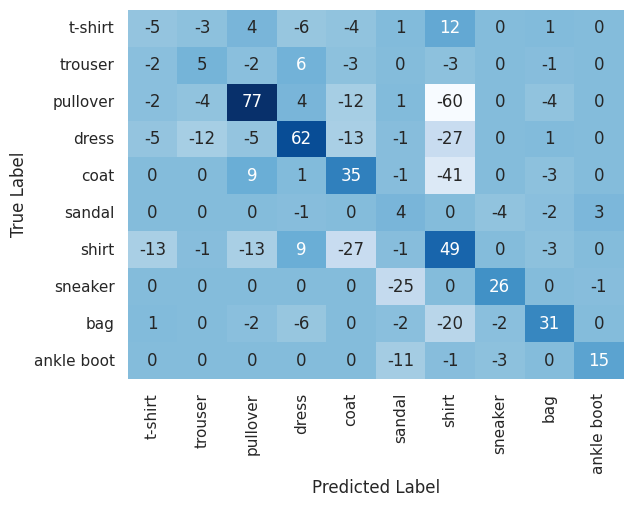
